# 4.0 Pose Sequence Analysis

`PoseSequenceAnalysis` class would be designed to analyze sequential changes in various pose aspects, such as face position, body position, and others. 

1. `get_total_spin_count()`: This method counts the number of times the face position changes from front to back or back to front, considering a change valid only if it's repeated in two consecutive instances.
2. `get_total_inversions()`: This method calculates the number of times the body position shifts from upright/horizontal to inverted, with similar logic to validate the change.
3. `get_pole_trick()`: Identifies pole tricks by comparing angle values with thresholds, returning the pose with the highest score or at least 5 points.

(To be continued)

In [1]:
import pandas as pd
import numpy as np
import re

class PoseSequenceAnalysis:
    def __init__(self, data, ref_tricks):
        self.data = data
        self.ref_tricks = ref_tricks
        self.trick_match_count = 0
        self.trick_undefined_count = 0
        
        self.spin_count = self.get_total_spin_count()
        self.invert_count = self.get_total_inversions()
        self.data['pos_trick'] = self.data.apply(self.get_pole_trick, axis=1)
        
    def get_total_spin_count(self):
        spin_count = 0
        faces = self.data['pos_face'].tolist()
    
        for i in range(2, len(faces)):
            if faces[i] != faces[i - 2] and faces[i] == faces[i - 1]:
                spin_count += 1

        return spin_count
        
    def get_total_inversions(self):
        inversion_count = 0
        bodies = self.data['pos_body'].tolist()
        
        for i in range(3, len(bodies)):
            if bodies[i] == 'inversion' and bodies[i - 1] != 'inversion' and bodies[i + 1] != 'inversion':
                inversion_count += 1
        return inversion_count
        
    def get_pole_trick(self, row):

        a_cols = sorted([col for col in self.data.columns if col.startswith('a_')])
        scores = {}
        for _, ref_row in self.ref_tricks.iterrows():
            score = 0
            
            for col in a_cols:
                threshold = 15
                difference = abs(row[col] - ref_row[col])
                if difference <= threshold:
                    score += 1
            
            scores[ref_row['pose_name']] = score
        
        closest_match_spec = max(scores, key=scores.get)
        highest_score = scores[closest_match_spec]
        
        if highest_score <= 5:
            self.trick_undefined_count += 1
            return "undefined"
        else:
            self.trick_match_count += 1
            suffixes_to_remove = r'(-rgt|-lft|-inv|-rgt-inv|-lft-inv|-center|)$'
            closest_match = re.sub(suffixes_to_remove, '', closest_match_spec)
            return closest_match

In [ ]:
ref_tricks = pd.read_csv('data/internal/tricks/pose_data.csv')
data = pd.read_csv('data/ground_truth/processed/upright/pose_data.csv')

results = PoseSequenceAnalysis(data, ref_tricks)

print("Total Spin Counts:", results.spin_count)
print("Total Invert Counts:", results.invert_count)
results.data[['secs','frame_no','pos_trick']].head(5)

In [ ]:
ref_tricks = pd.read_csv('data/internal/tricks/pose_data.csv')
data = pd.read_csv('data/ground_truth/processed/combined/pose_data.csv')

results = PoseSequenceAnalysis(data, ref_tricks)

print("Total Spin Counts:", results.spin_count)
print("Total Invert Counts:", results.invert_count)
results.data[['secs','frame_no','pos_trick']].head(5)

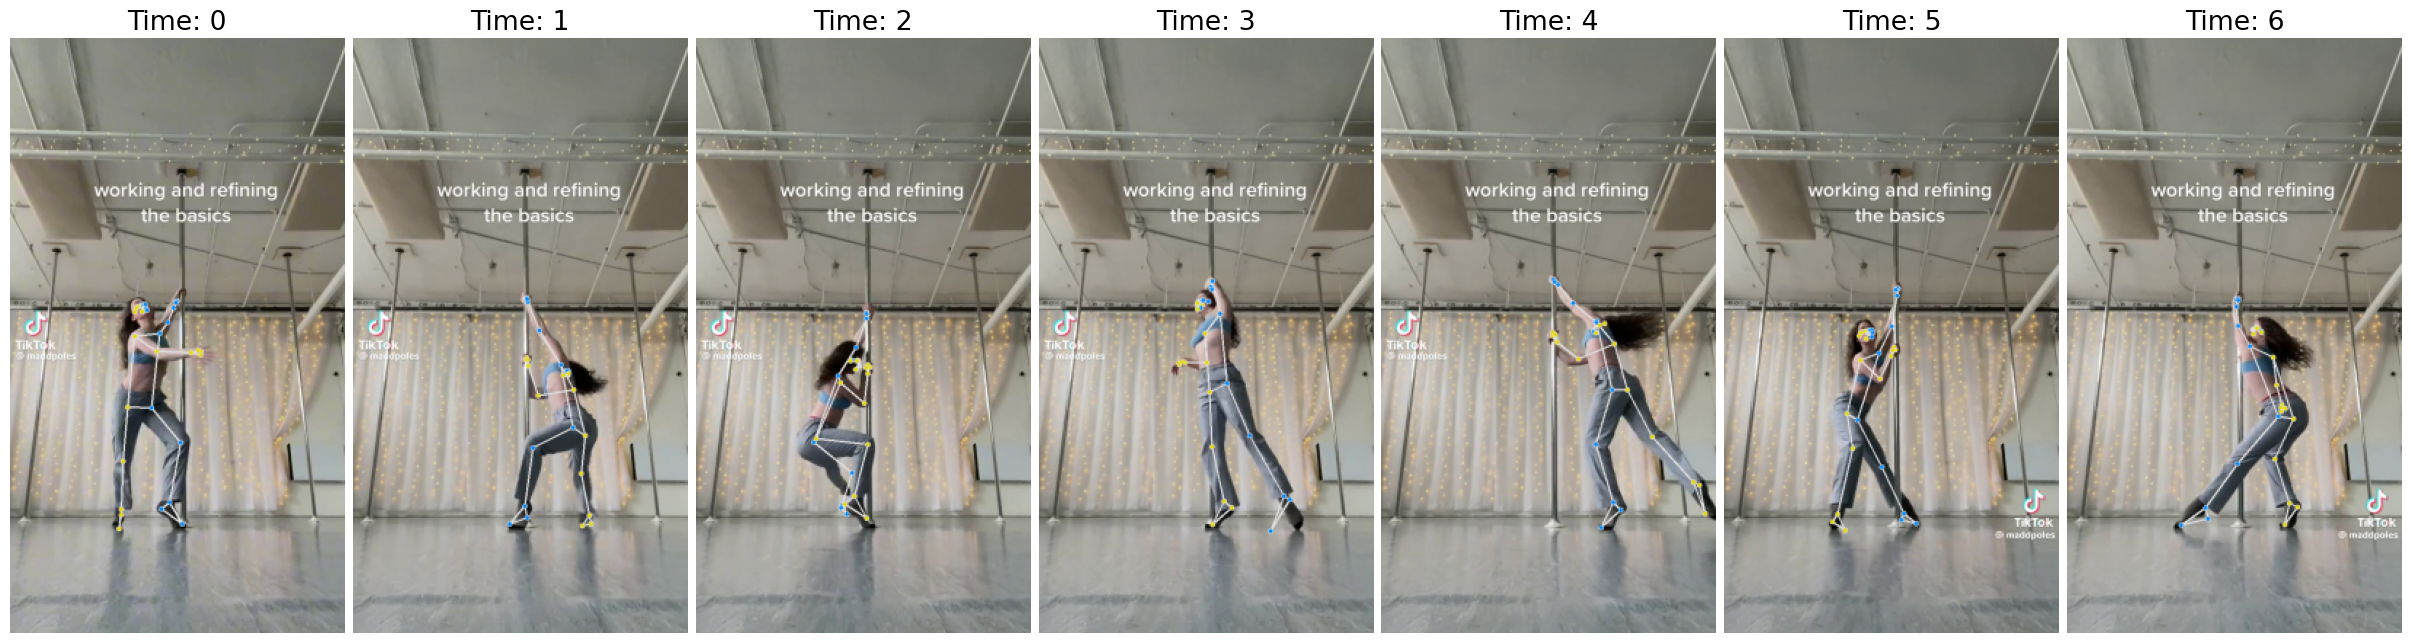

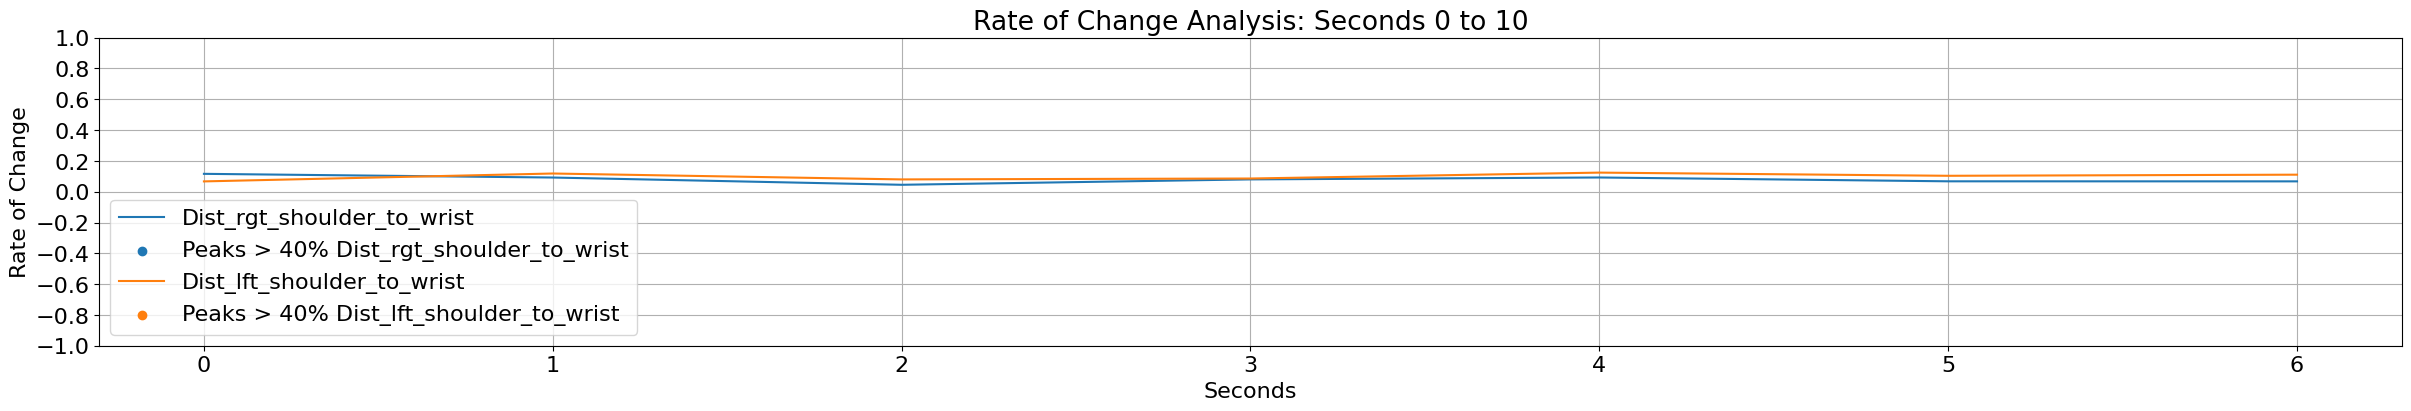

In [2]:
from helpers.file_system_utils import *
from helpers.data_visualization_utils import *

data = pd.read_csv('data/ground_truth/processed/upright/pose_data2.csv')
annotated_image_path_dir = 'data/ground_truth/processed/upright/annotated/'
visualize_video_frames_by_second(annotated_image_path_dir, data)
visualize_roc_trends(data)